In [25]:
# Imports
# Load the TensorBoard notebook extension
import cv2
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [26]:
# Declare preprocessing functions
img_size = 128
def get_label(file_path: str):
    parsed = tf.strings.split(file_path, os.path.sep)
    parent = parsed[-2]
    file_name = parsed[-1]
    if parent == "PNEUMONIA":
        label_str = tf.strings.split(file_name, '_')[1]
    else:
        label_str = parent
    return tf.argmax(label_str == class_names)


def decode_img(img):
    
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_image(img, channels=3, dtype= tf.dtypes.uint8)

    # Check the number of channels
    num_channels = tf.shape(img)[-1]

    # Convert RGB to grayscale if necessary
    if num_channels == 3:
        img = tf.image.rgb_to_grayscale(img)
    # get image dimensions
    img_shape = tf.shape(img).numpy()

    width, height = img_shape[0], img_shape[1]
    min_dimension = tf.math.minimum(width, height).numpy()

    crop_size = tf.constant([min_dimension, min_dimension, 1], dtype='int32')
    # Implement random cropping
    img = tf.image.random_crop(value=img, size=crop_size)
    img = tf.cast(img, tf.float32)/255 # Explicitly cast to float32 and normalize
    return tf.image.resize(img, [img_size, img_size], method='nearest', preserve_aspect_ratio=False)


@tf.function
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.py_function(decode_img, [img], tf.float32)
    return img, label

@tf.function
def process_path_and_augment(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.py_function(decode_img, [img], tf.float32)
    img = tf.py_function(data_augmentation, [img], tf.float32)

    return img, label


def data_augmentation(image):
    # Apply data augmentation operations to the image

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    return image



In [27]:
# Preprocessing
class_names = np.array(['NORMAL', 'bacteria', 'virus'])


# path_to_dir = os.environ.get("DATASET_PATH")
path_to_dir = "/Volumes/KINGSTON/Pnemonia Dataset/chest_xray"
if path_to_dir is None:
    os.environ["DATASET_PATH"] = input("Enter complete path to the chest_xray folder: ")
    path_to_dir = os.environ["DATASET_PATH"]
    print("You should set the DATASET_PATH enviroment variable to avoid this every time you run the program.")



ds_files = [str(file.absolute()) for file in pathlib.Path(path_to_dir).glob("**/[!._]*.jpeg")]

train_files, val_files = train_test_split(ds_files, test_size=0.3, train_size=0.7)

# There's 2x more baceria samples than normal and viral.
# Duplicating viral and normal images and augmenting training dataset.
# This will help the model generalize better.
duplicates = []
progress = 0
for file in train_files:
    if progress % 50 == 0:
        print(f"images sorted: {progress}")
    if class_names[get_label(file)] != "bacteria":
        duplicates.append(file)
    progress += 1
train_files = train_files + duplicates
print(f"train size: {len(train_files)}")
print(f"val size: {len(val_files)}")



train_ds = tf.data.Dataset.from_tensor_slices(train_files)
image_count = len(train_files)
train_ds = train_ds.shuffle(image_count, reshuffle_each_iteration=True)

val_ds = tf.data.Dataset.from_tensor_slices(val_files)
image_count = len(val_ds)
val_ds = val_ds.shuffle(image_count, reshuffle_each_iteration=True)


for f in train_ds.take(5):
    print(f.numpy())



# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path_and_augment, num_parallel_calls=tf.data.AUTOTUNE)

# We do not augment the val dataset to retain data integrity.
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)




images sorted: 0
images sorted: 50
images sorted: 100
images sorted: 150
images sorted: 200
images sorted: 250
images sorted: 300
images sorted: 350
images sorted: 400
images sorted: 450
images sorted: 500
images sorted: 550
images sorted: 600
images sorted: 650
images sorted: 700
images sorted: 750
images sorted: 800
images sorted: 850
images sorted: 900
images sorted: 950
images sorted: 1000
images sorted: 1050
images sorted: 1100
images sorted: 1150
images sorted: 1200
images sorted: 1250
images sorted: 1300
images sorted: 1350
images sorted: 1400
images sorted: 1450
images sorted: 1500
images sorted: 1550
images sorted: 1600
images sorted: 1650
images sorted: 1700
images sorted: 1750
images sorted: 1800
images sorted: 1850
images sorted: 1900
images sorted: 1950
images sorted: 2000
images sorted: 2050
images sorted: 2100
images sorted: 2150
images sorted: 2200
images sorted: 2250
images sorted: 2300
images sorted: 2350
images sorted: 2400
images sorted: 2450
images sorted: 2500
ima

Image shape:  (128, 128, 1)
Label:  2
Label Shape:  ()
Type:  virus


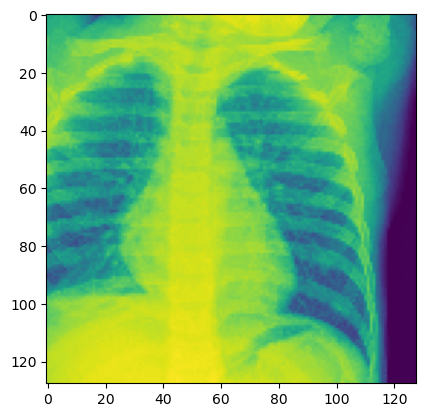

Image shape:  (128, 128, 1)
Label:  0
Label Shape:  ()
Type:  NORMAL


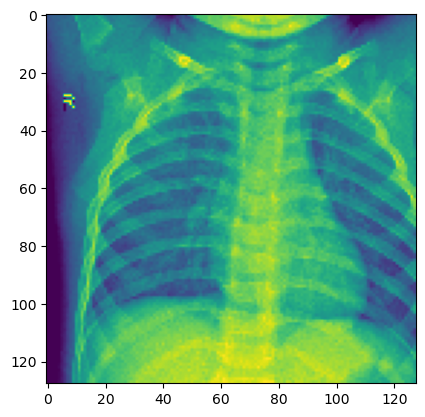

Image shape:  (128, 128, 1)
Label:  2
Label Shape:  ()
Type:  virus


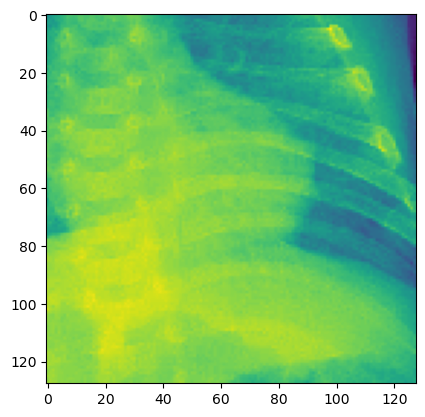

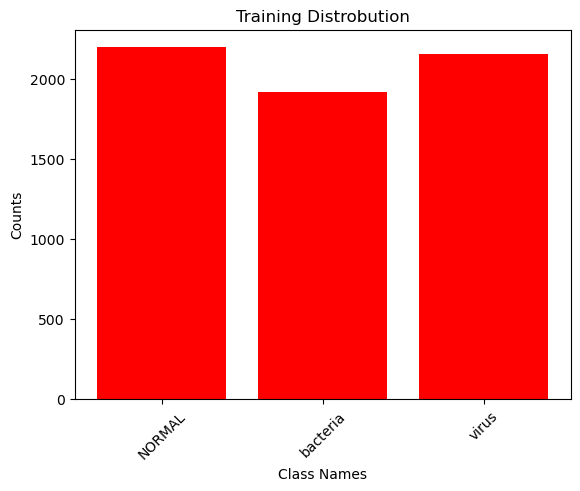

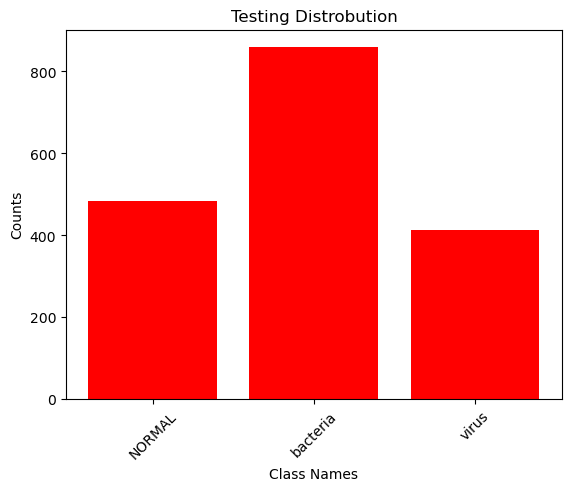

In [28]:
# View sample of dataset

for image, label in train_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("Label Shape: ", label.numpy().shape)
    print("Type: ", class_names[label.numpy()])
    plt.imshow(image.numpy())
    plt.show()

view_dist = input("Would you like to view the sample distribution? (Y/n)\n>> ")
if view_dist=='Y':
    # View distrobution of samples:
    count = {"NORMAL": 0,
             "bacteria": 0,
             "virus": 0}
    for image, label in train_ds:
        count[class_names[label]] += 1

    plt.bar(class_names, count.values(), color='red')
    plt.xlabel('Class Names')
    plt.ylabel('Counts')
    plt.title('Training Distribution')
    plt.xticks(rotation=45)
    plt.show()

# View distrobution of samples:
    count = {"NORMAL": 0,
             "bacteria": 0,
             "virus": 0}
    for image, label in val_ds:
        count[class_names[label]] += 1

    plt.bar(class_names, count.values(), color='red')
    plt.xlabel('Class Names')
    plt.ylabel('Counts')
    plt.title('Testing Distribution')
    plt.xticks(rotation=45)
    plt.show()



In [29]:


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 batch_normalization_2 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 64)       

Training set size:  6336
Validation set size:  1792
99
Epoch 1/12
99/99 [==============================] - 74s 740ms/step - loss: 0.9378 - accuracy: 0.6011 - val_loss: 1.0139 - val_accuracy: 0.5242
Epoch 2/12
99/99 [==============================] - 74s 740ms/step - loss: 0.6765 - accuracy: 0.6846 - val_loss: 0.9961 - val_accuracy: 0.5709
Epoch 3/12
99/99 [==============================] - 73s 738ms/step - loss: 0.6025 - accuracy: 0.7230 - val_loss: 0.9392 - val_accuracy: 0.4445
Epoch 4/12
99/99 [==============================] - 80s 805ms/step - loss: 0.5758 - accuracy: 0.7311 - val_loss: 0.7363 - val_accuracy: 0.7530
Epoch 5/12
99/99 [==============================] - 85s 854ms/step - loss: 0.5870 - accuracy: 0.7215 - val_loss: 0.6997 - val_accuracy: 0.7371
Epoch 6/12
99/99 [==============================] - 235s 2s/step - loss: 0.5497 - accuracy: 0.7483 - val_loss: 0.6377 - val_accuracy: 0.7223
Epoch 7/12
99/99 [==============================] - 209s 2s/step - loss: 0.5358 - accurac

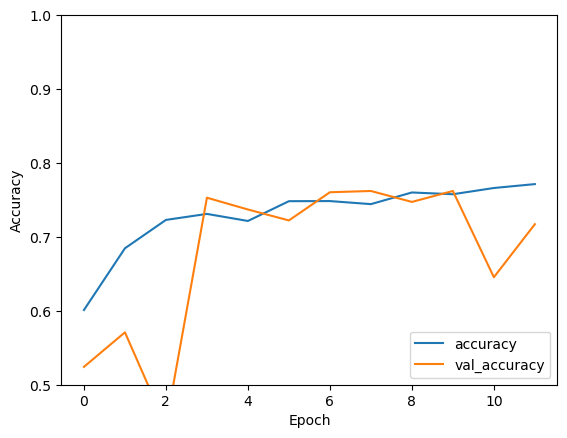

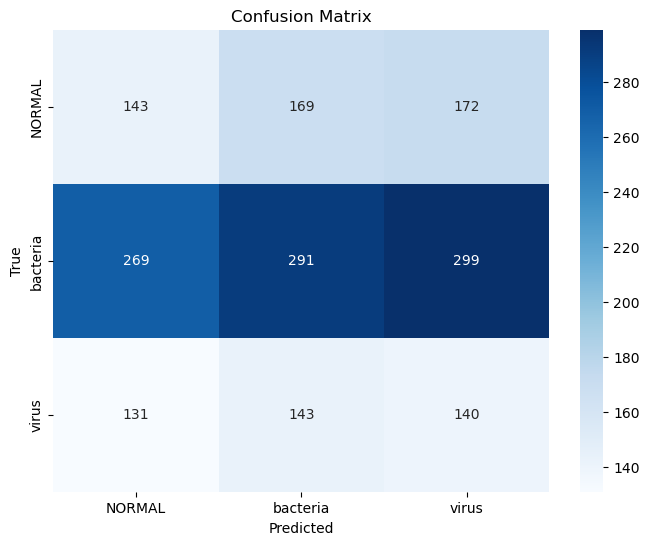

In [30]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
# Batching
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

print('Training set size: ', len(train_ds)*batch_size)
print('Validation set size: ', len(val_ds)*batch_size)

# Define callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('xray_model.keras', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Define number of epochs and steps per epoch
epochs = 12
steps_per_epoch = len(train_ds)
validation_steps = len(val_ds) 

print(steps_per_epoch)


# Train the model using model.fit
history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(val_ds, verbose=2)
y_pred_probabilities = model.predict(val_ds)
y_true = []
for _, label in val_ds:
    y_true.append(label.numpy())

y_true_stacks = [np.argmax(label.numpy(), axis=1) if len(label.numpy().shape) > 1 else label.numpy() for _, label in val_ds]
y_true_classes = np.concatenate(y_true_stacks, axis=0)

y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
confusion = confusion_matrix(y_true_classes, y_pred_classes)
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




In [31]:
model.save("xray_model_post_train2.keras")

In [32]:
# Freeze convolutional layers, then make a new model with those layers
fine_model = models.Sequential()
for layer in model.layers[:6]:
    layer.trainable = False
    fine_model.add(layer)
fine_model.add(layers.MaxPooling2D((2, 2)))
fine_model.add(layers.BatchNormalization())
fine_model.add(layers.MaxPooling2D((2, 2)))
fine_model.add(layers.Dropout(0.1))
fine_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
fine_model.add(layers.MaxPooling2D((2, 2)))
fine_model.add(layers.Dropout(0.1))
fine_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
fine_model.add(layers.Flatten())
fine_model.add(layers.Dense(64, activation='relu'))
fine_model.add(layers.Dropout(0.3))
fine_model.add(layers.Dense(3, activation='softmax'))

fine_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

epochs = 20

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('xray_model_fine_tune_v3.keras', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')


# Train the model using model.fit
history = fine_model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = fine_model.evaluate(val_ds, verbose=2)

#test_loss, test_acc = model.evaluate(val_ds, verbose=2)
y_pred_probabilities = model.predict(val_ds)
y_true = []
for _, label in val_ds:
    y_true.append(label.numpy())

y_true_stacks = [np.argmax(label.numpy(), axis=1) if len(label.numpy().shape) > 1 else label.numpy() for _, label in val_ds]
y_true_classes = np.concatenate(y_true_stacks, axis=0)

y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
confusion = confusion_matrix(y_true_classes, y_pred_classes)
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/20
99/99 [==============================] - 142s 1s/step - loss: 0.7357 - accuracy: 0.6384 - val_loss: 0.8519 - val_accuracy: 0.5874
Epoch 2/20
99/99 [==============================] - 141s 1s/step - loss: 0.5787 - accuracy: 0.7255 - val_loss: 0.6270 - val_accuracy: 0.7251
Epoch 3/20
99/99 [==============================] - 133s 1s/step - loss: 0.5702 - accuracy: 0.7351 - val_loss: 0.5993 - val_accuracy: 0.7359
Epoch 4/20
99/99 [==============================] - 131s 1s/step - loss: 0.5438 - accuracy: 0.7419 - val_loss: 0.6645 - val_accuracy: 0.6699
Epoch 5/20
99/99 [==============================] - 129s 1s/step - loss: 0.5284 - accuracy: 0.7507 - val_loss: 0.5625 - val_accuracy: 0.7752
Epoch 6/20
99/99 [==============================] - 126s 1s/step - loss: 0.5187 - accuracy: 0.7634 - val_loss: 0.6137 - val_accuracy: 0.6756
Epoch 7/20
99/99 [==============================] - 135s 1s/step - loss: 0.5073 - accuracy: 0.7725 - val_loss: 0.6708 - val_accuracy: 0.6067
Epoch 8/20
99

KeyboardInterrupt: 

In [ ]:
## Now, let's just train the dense layers

for layer in fine_model.layers[:14]:
    layer.trainable = False

fine_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

epochs = 100

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('xray_model_fine_tune_v4.keras', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')


# Train the model using model.fit
history = fine_model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(val_ds, verbose=2)
y_pred_probabilities = model.predict(val_ds)
y_true = []
for _, label in val_ds:
    y_true.append(label.numpy())

y_true_stacks = [np.argmax(label.numpy(), axis=1) if len(label.numpy().shape) > 1 else label.numpy() for _, label in val_ds]
y_true_classes = np.concatenate(y_true_stacks, axis=0)

y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
confusion = confusion_matrix(y_true_classes, y_pred_classes)
report = classification_report(y_true_classes, y_pred_classes)
print(report)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/100
99/99 [==============================] - 53s 530ms/step - loss: 0.5101 - accuracy: 0.7716 - val_loss: 0.5929 - val_accuracy: 0.7262
Epoch 2/100
99/99 [==============================] - 53s 541ms/step - loss: 0.5030 - accuracy: 0.7703 - val_loss: 0.5682 - val_accuracy: 0.7718
Epoch 3/100
99/99 [==============================] - 52s 522ms/step - loss: 0.5040 - accuracy: 0.7703 - val_loss: 0.5421 - val_accuracy: 0.7706
Epoch 4/100
99/99 [==============================] - 52s 522ms/step - loss: 0.4988 - accuracy: 0.7754 - val_loss: 0.5790 - val_accuracy: 0.7490
Epoch 5/100
99/99 [==============================] - 52s 527ms/step - loss: 0.4985 - accuracy: 0.7741 - val_loss: 0.5846 - val_accuracy: 0.7445
Epoch 6/100
99/99 [==============================] - 51s 519ms/step - loss: 0.5045 - accuracy: 0.7721 - val_loss: 0.5736 - val_accuracy: 0.7473
Epoch 7/100
27/99 [=======>......................] - ETA: 28s - loss: 0.5122 - accuracy: 0.7668

KeyboardInterrupt: 